In [6]:
import sys
print(f"Python version: {sys.version}")

try:
    import torch
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
except ImportError:
    print("PyTorch is not installed")

try:
    import pandas as pd
    print(f"Pandas version: {pd.__version__}")
except ImportError:
    print("Pandas is not installed")

try:
    import matplotlib
    import matplotlib.pyplot as plt
    print(f"Matplotlib version: {matplotlib.__version__}")
except ImportError:
    print("Matplotlib is not installed")

Python version: 3.13.3 (tags/v3.13.3:6280bb5, Apr  8 2025, 14:47:33) [MSC v.1943 64 bit (AMD64)]
PyTorch version: 2.7.0+cpu
CUDA available: False
Pandas version: 2.2.3
Matplotlib version: 3.10.3


Exploring dataset structure...
Total number of classes: 9
Total number of images: 5548

Distribution of images per class:


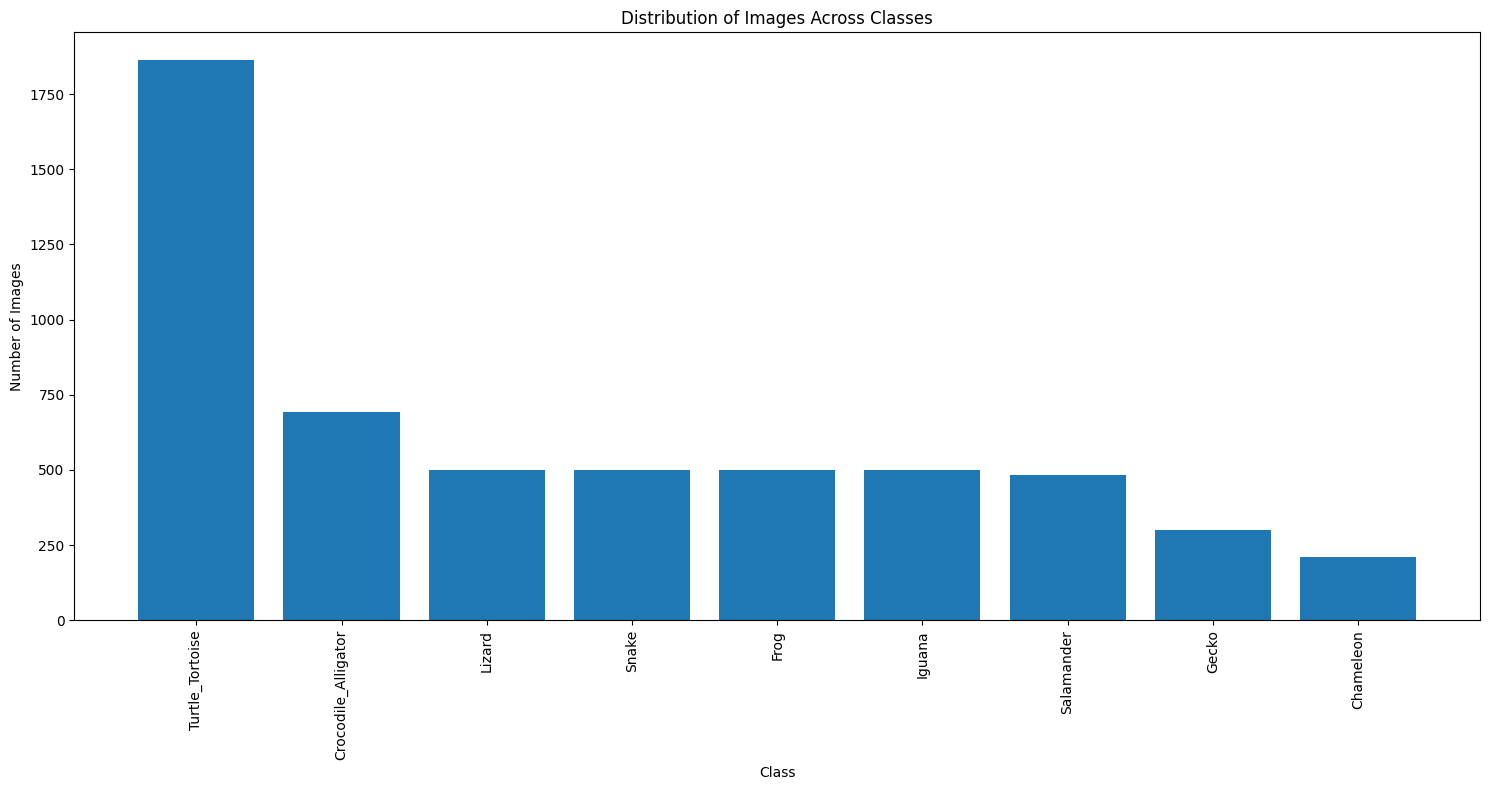

Turtle_Tortoise: 1862 images (33.56%)
Crocodile_Alligator: 692 images (12.47%)
Lizard: 500 images (9.01%)
Snake: 500 images (9.01%)
Frog: 499 images (8.99%)
Iguana: 499 images (8.99%)
Salamander: 484 images (8.72%)
Gecko: 302 images (5.44%)
Chameleon: 210 images (3.79%)


In [12]:
# Explore dataset structure
import os

def explore_dataset(data_dir):
    print("Exploring dataset structure...")
    class_counts = {}
    total_images = 0
    
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[class_name] = num_images
            total_images += num_images
    
    # Sort classes by number of images (descending)
    sorted_classes = {k: v for k, v in sorted(class_counts.items(), key=lambda item: item[1], reverse=True)}
    
    print(f"Total number of classes: {len(class_counts)}")
    print(f"Total number of images: {total_images}")
    print("\nDistribution of images per class:")
    
    # Plot class distribution
    plt.figure(figsize=(15, 8))
    plt.bar(sorted_classes.keys(), sorted_classes.values())
    plt.xticks(rotation=90)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Distribution of Images Across Classes')
    plt.tight_layout()
    plt.show()
    
    # Print stats
    for class_name, count in sorted_classes.items():
        print(f"{class_name}: {count} images ({count/total_images*100:.2f}%)")
    
    return sorted_classes

# Run the exploration
class_distribution = explore_dataset('archive')

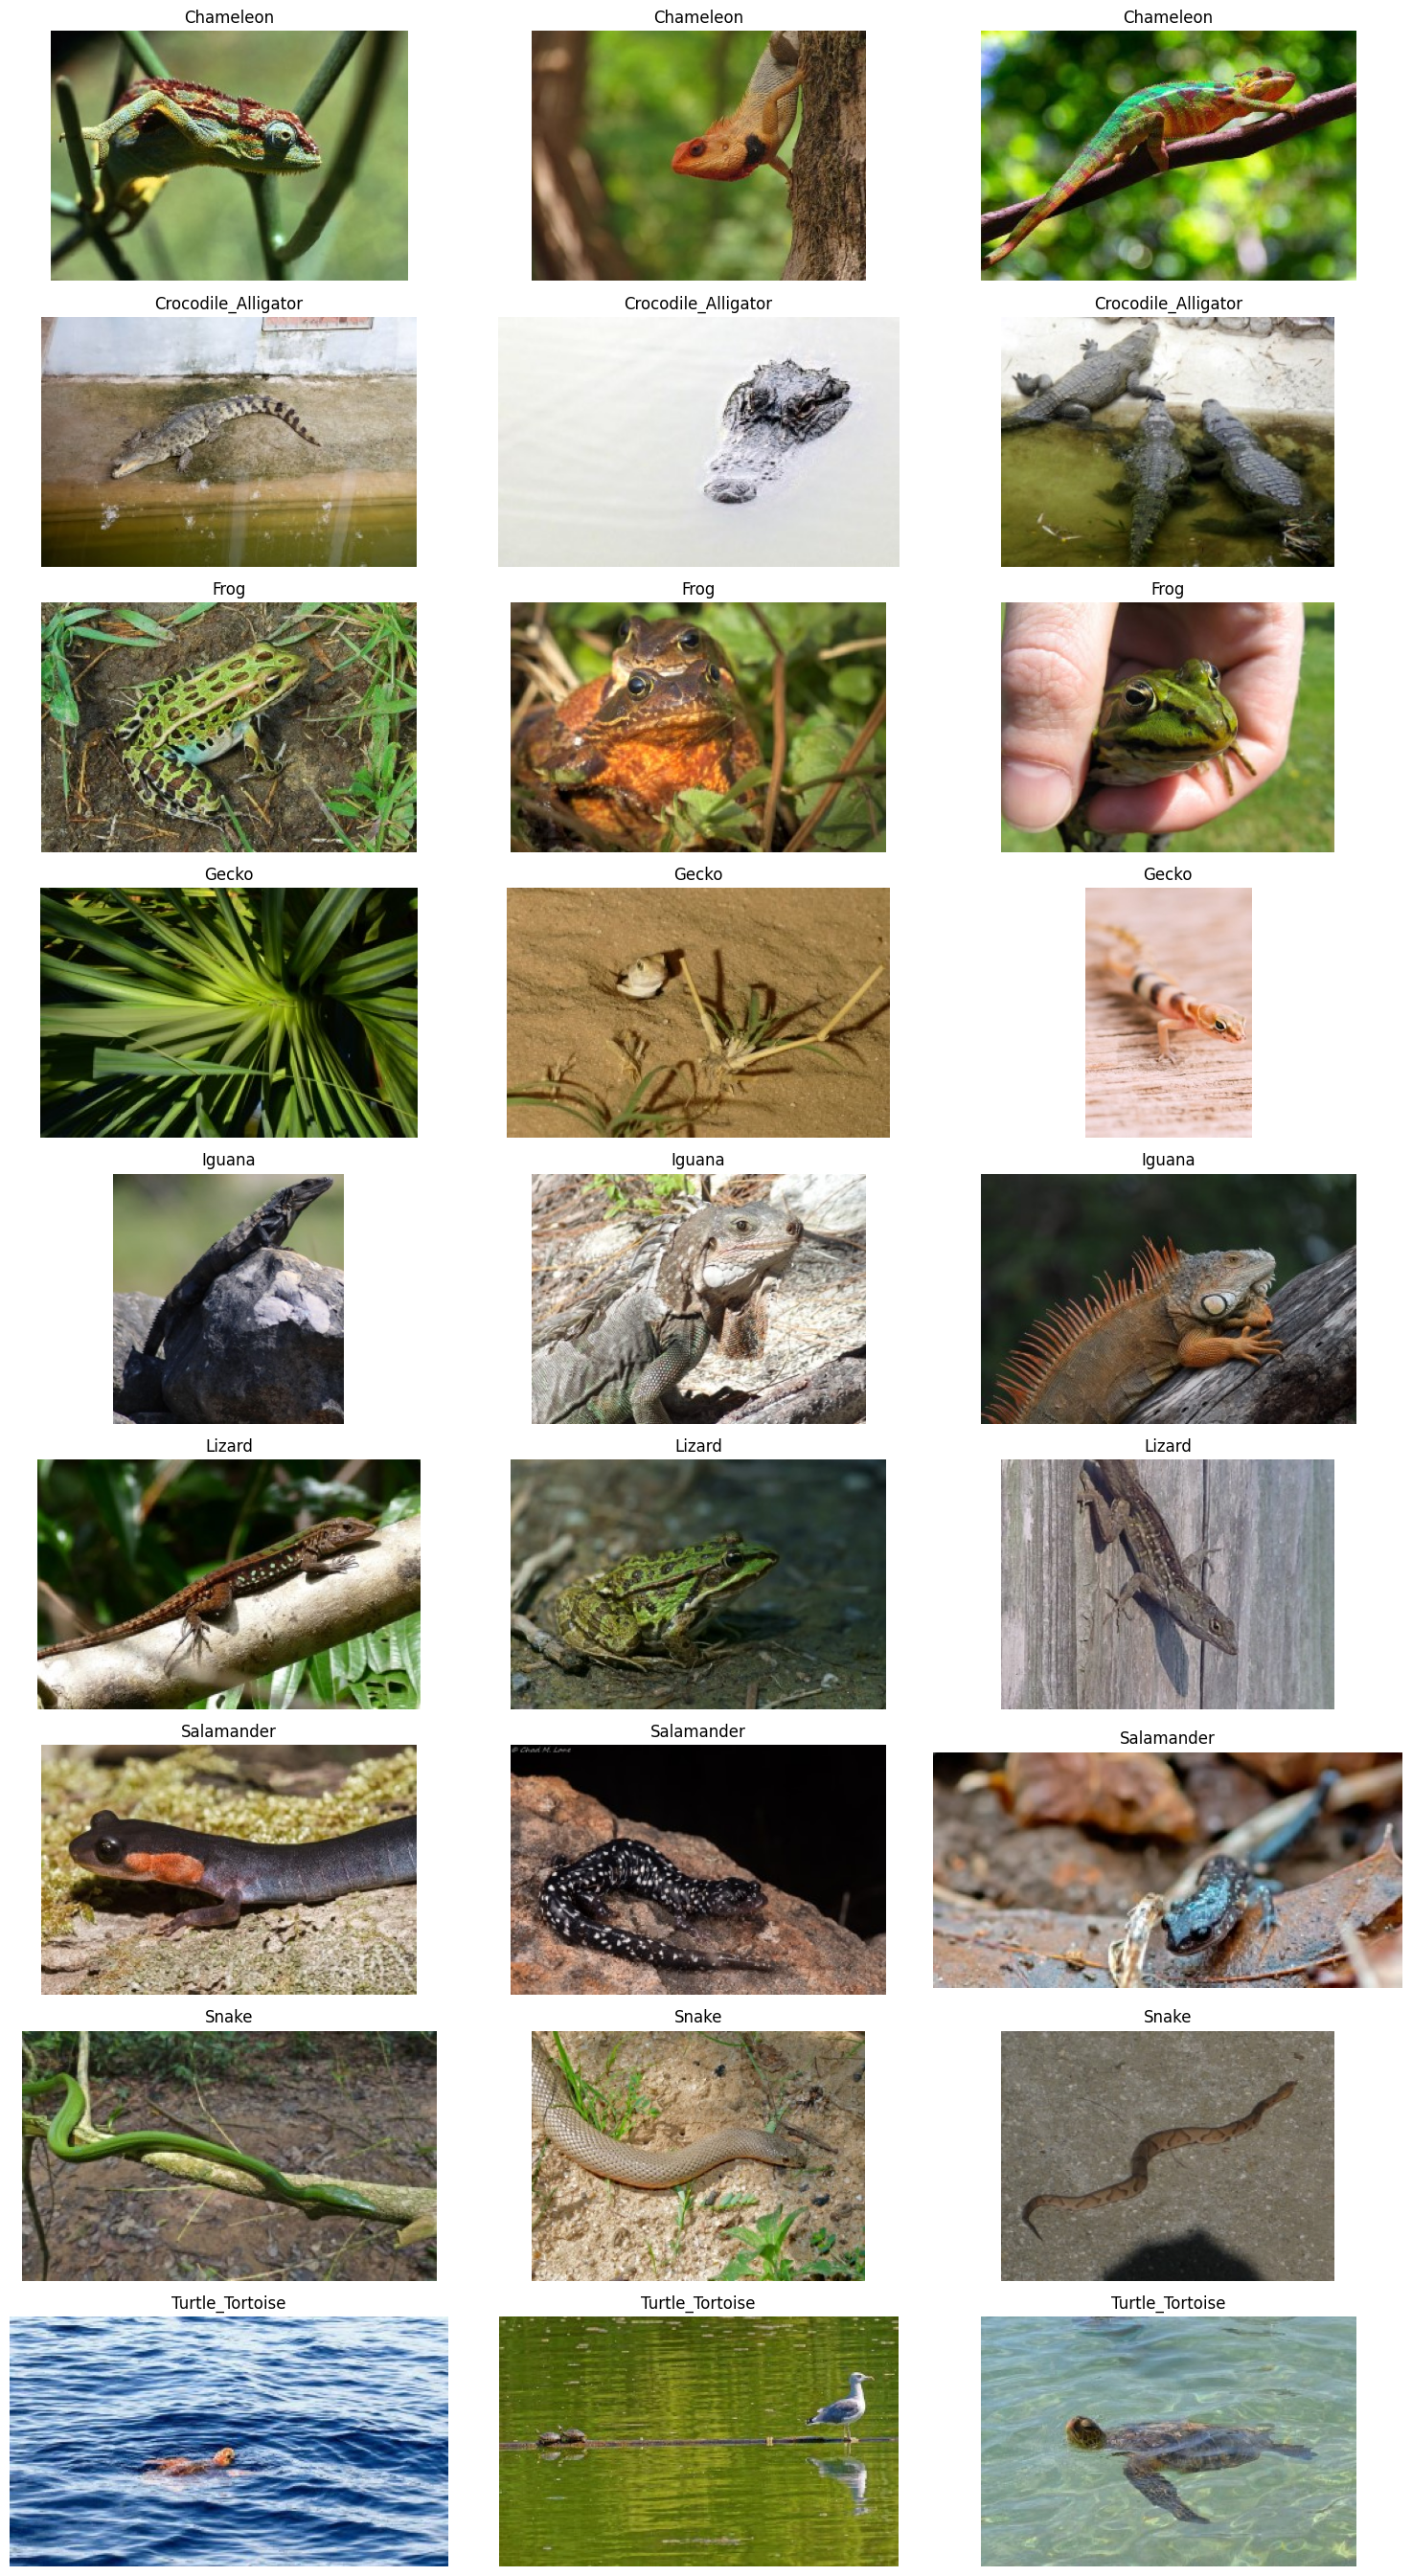

In [13]:
# Visualize sample images from each class
from PIL import Image
import random
import matplotlib.pyplot as plt

def show_sample_images(data_dir, num_classes=9, samples_per_class=3):
    # Get all class directories
    class_dirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    
    # Randomly select classes if there are more than we want to display
    if len(class_dirs) > num_classes:
        selected_classes = random.sample(class_dirs, num_classes)
    else:
        selected_classes = class_dirs
    
    fig, axs = plt.subplots(num_classes, samples_per_class, figsize=(15, 3*num_classes))
    
    for i, class_name in enumerate(selected_classes):
        class_path = os.path.join(data_dir, class_name)
        image_files = os.listdir(class_path)
        
        # Randomly select images
        if len(image_files) > samples_per_class:
            selected_images = random.sample(image_files, samples_per_class)
        else:
            selected_images = image_files
        
        for j, img_file in enumerate(selected_images):
            img_path = os.path.join(class_path, img_file)
            img = Image.open(img_path)
            
            # Display image
            axs[i, j].imshow(img)
            axs[i, j].set_title(f"{class_name}")
            axs[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Show sample images
show_sample_images('archive')

In [15]:
# Create directories for train/val/test splits
import shutil
from sklearn.model_selection import train_test_split

def prepare_dataset(data_dir='archive', train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    """
    Split the dataset into train, validation, and test sets.
    """
    # Create main data directories
    os.makedirs('data/train', exist_ok=True)
    os.makedirs('data/val', exist_ok=True)
    os.makedirs('data/test', exist_ok=True)
    
    # Dictionary to keep track of class statistics
    class_stats = {}
    
    # Process each class directory
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            images = [img for img in os.listdir(class_path) 
                     if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
            
            # Skip if no valid images
            if not images:
                print(f"No valid images found in {class_name}, skipping...")
                continue
                
            # Create train-val-test split
            train_images, temp_images = train_test_split(
                images, 
                test_size=(val_size + test_size),
                random_state=random_state
            )
            
            # Further split temp_images into val and test
            val_ratio = val_size / (val_size + test_size)
            val_images, test_images = train_test_split(
                temp_images,
                test_size=(1-val_ratio),
                random_state=random_state
            )
            
            # Store statistics
            class_stats[class_name] = {
                'total': len(images),
                'train': len(train_images),
                'val': len(val_images),
                'test': len(test_images)
            }
            
            # Create class directories in each split
            os.makedirs(f'data/train/{class_name}', exist_ok=True)
            os.makedirs(f'data/val/{class_name}', exist_ok=True)
            os.makedirs(f'data/test/{class_name}', exist_ok=True)
            
            # Copy images
            for img in train_images:
                shutil.copy(os.path.join(class_path, img), f'data/train/{class_name}/{img}')
            for img in val_images:
                shutil.copy(os.path.join(class_path, img), f'data/val/{class_name}/{img}')
            for img in test_images:
                shutil.copy(os.path.join(class_path, img), f'data/test/{class_name}/{img}')
    
    # Print summary
    print(f"Dataset preparation complete!")
    print(f"Total classes: {len(class_stats)}")
    
    # Calculate totals
    total_images = sum(stats['total'] for stats in class_stats.values())
    total_train = sum(stats['train'] for stats in class_stats.values())
    total_val = sum(stats['val'] for stats in class_stats.values())
    total_test = sum(stats['test'] for stats in class_stats.values())
    
    print(f"Total images: {total_images}")
    print(f"Training set: {total_train} images ({total_train/total_images*100:.2f}%)")
    print(f"Validation set: {total_val} images ({total_val/total_images*100:.2f}%)")
    print(f"Test set: {total_test} images ({total_test/total_images*100:.2f}%)")
    
    return class_stats

# Create train/val/test splits
class_stats = prepare_dataset()

Dataset preparation complete!
Total classes: 9
Total images: 5547
Training set: 3880 images (69.95%)
Validation set: 832 images (15.00%)
Test set: 835 images (15.05%)


In [16]:
# Create data loaders with augmentation
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

def get_data_loaders(batch_size=32, img_size=224):
    # Define transformations with augmentation for training
    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Simpler transformations for validation and testing
    val_test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Create datasets
    train_dataset = datasets.ImageFolder('data/train', transform=train_transform)
    val_dataset = datasets.ImageFolder('data/val', transform=val_test_transform)
    test_dataset = datasets.ImageFolder('data/test', transform=val_test_transform)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    # Get class names
    class_names = train_dataset.classes
    class_to_idx = train_dataset.class_to_idx
    
    return train_loader, val_loader, test_loader, class_names, class_to_idx

train_loader, val_loader, test_loader, class_names, class_to_idx = get_data_loaders()

print(f"Number of classes: {len(class_names)}")
print(f"Class names: {class_names}")

Number of classes: 9
Class names: ['Chameleon', 'Crocodile_Alligator', 'Frog', 'Gecko', 'Iguana', 'Lizard', 'Salamander', 'Snake', 'Turtle_Tortoise']


In [17]:
# Define and train the model
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
import time

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=15):
    """
    Train the model and return training history.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    best_val_acc = 0.0
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Train)'):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        # Calculate training metrics
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Val)'):
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
        # Calculate validation metrics
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total
        
        # Update learning rate if scheduler exists
        if scheduler is not None:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Model saved with validation accuracy: {val_acc:.4f}')
    
    time_elapsed = time.time() - start_time
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best validation accuracy: {best_val_acc:.4f}')
    
    return model, history

# Create model (ResNet50 with transfer learning)
model = models.resnet50(pretrained=True)
num_classes = len(class_names)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Train the model
trained_model, history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15)

C:\Users\erics\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\erics\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\erics/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:07<00:00, 12.8MB/s]
Epoch 1/15 (Val): 100%|██████████| 26/26 [00:22<00:00,  1.16it/s]


Epoch 1/15:
Train Loss: 1.6427, Train Acc: 0.4603
Val Loss: 1.6613, Val Acc: 0.4339
Model saved with validation accuracy: 0.4339


Epoch 2/15 (Val): 100%|██████████| 26/26 [00:22<00:00,  1.15it/s]


Epoch 2/15:
Train Loss: 1.3473, Train Acc: 0.5474
Val Loss: 1.3647, Val Acc: 0.5613
Model saved with validation accuracy: 0.5613


Epoch 3/15 (Val): 100%|██████████| 26/26 [00:22<00:00,  1.15it/s]


Epoch 3/15:
Train Loss: 1.1532, Train Acc: 0.6162
Val Loss: 1.1617, Val Acc: 0.6226
Model saved with validation accuracy: 0.6226


Epoch 4/15 (Val): 100%|██████████| 26/26 [00:22<00:00,  1.15it/s]


Epoch 4/15:
Train Loss: 1.0633, Train Acc: 0.6456
Val Loss: 1.3981, Val Acc: 0.5637


Epoch 5/15 (Val): 100%|██████████| 26/26 [00:22<00:00,  1.17it/s]


Epoch 5/15:
Train Loss: 0.9705, Train Acc: 0.6784
Val Loss: 1.3436, Val Acc: 0.5421


Epoch 6/15 (Val): 100%|██████████| 26/26 [00:21<00:00,  1.19it/s]


Epoch 6/15:
Train Loss: 0.8858, Train Acc: 0.7129
Val Loss: 1.0054, Val Acc: 0.6683
Model saved with validation accuracy: 0.6683


Epoch 7/15 (Val): 100%|██████████| 26/26 [00:22<00:00,  1.18it/s]


Epoch 7/15:
Train Loss: 0.8203, Train Acc: 0.7250
Val Loss: 1.0476, Val Acc: 0.6394


Epoch 8/15 (Val): 100%|██████████| 26/26 [00:24<00:00,  1.04it/s]


Epoch 8/15:
Train Loss: 0.7609, Train Acc: 0.7539
Val Loss: 1.0652, Val Acc: 0.6731
Model saved with validation accuracy: 0.6731


Epoch 9/15 (Val): 100%|██████████| 26/26 [00:24<00:00,  1.05it/s]


Epoch 9/15:
Train Loss: 0.7298, Train Acc: 0.7624
Val Loss: 1.1247, Val Acc: 0.6358


Epoch 10/15 (Val): 100%|██████████| 26/26 [00:22<00:00,  1.18it/s]


Epoch 10/15:
Train Loss: 0.7350, Train Acc: 0.7621
Val Loss: 1.1176, Val Acc: 0.6587


Epoch 11/15 (Val): 100%|██████████| 26/26 [00:21<00:00,  1.19it/s]


Epoch 11/15:
Train Loss: 0.5006, Train Acc: 0.8423
Val Loss: 0.7004, Val Acc: 0.7776
Model saved with validation accuracy: 0.7776


Epoch 12/15 (Val): 100%|██████████| 26/26 [00:21<00:00,  1.19it/s]


Epoch 12/15:
Train Loss: 0.4017, Train Acc: 0.8719
Val Loss: 0.6820, Val Acc: 0.7837
Model saved with validation accuracy: 0.7837


Epoch 13/15 (Val): 100%|██████████| 26/26 [00:21<00:00,  1.21it/s]


Epoch 13/15:
Train Loss: 0.3616, Train Acc: 0.8892
Val Loss: 0.7138, Val Acc: 0.7752


Epoch 14/15 (Val): 100%|██████████| 26/26 [00:21<00:00,  1.20it/s]


Epoch 14/15:
Train Loss: 0.3333, Train Acc: 0.8982
Val Loss: 0.7172, Val Acc: 0.7752


Epoch 15/15 (Val): 100%|██████████| 26/26 [00:22<00:00,  1.14it/s]

Epoch 15/15:
Train Loss: 0.3145, Train Acc: 0.9005
Val Loss: 0.7061, Val Acc: 0.7837
Training complete in 86m 9s
Best validation accuracy: 0.7837


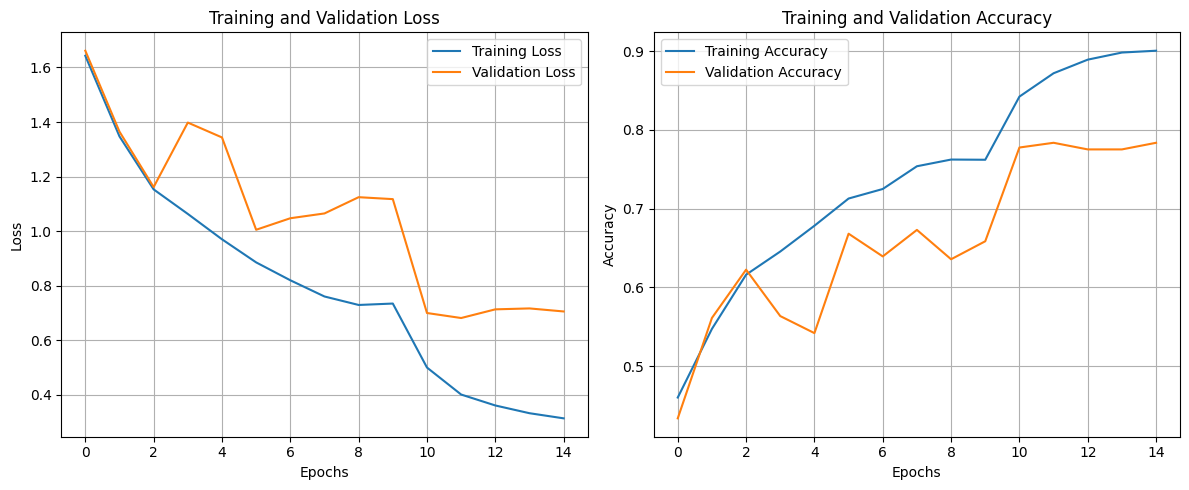

In [18]:
# Plot training history
def plot_training_history(history):
    """
    Plot training and validation loss and accuracy.
    """
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

Evaluating: 100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


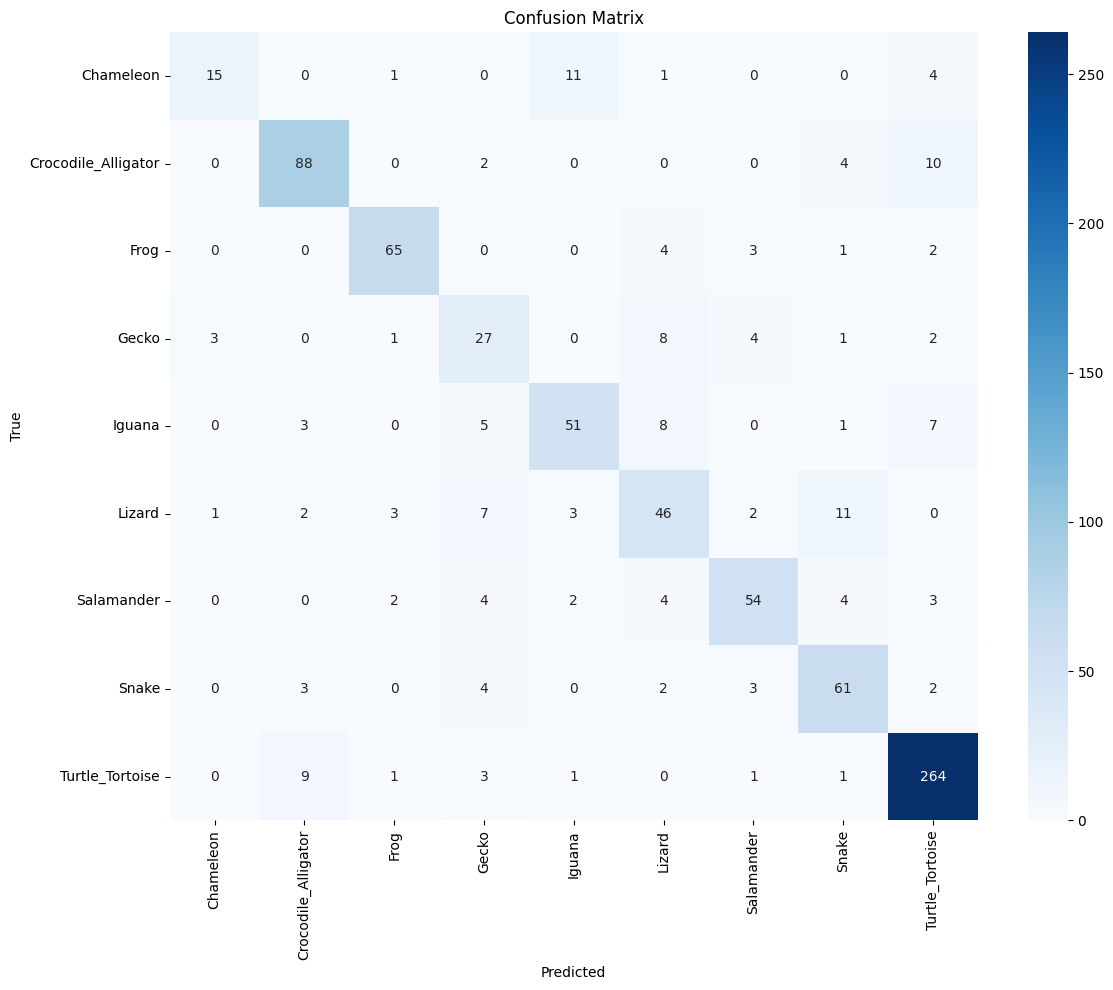

Test Loss: 0.6277
Classification Report:
                     precision    recall  f1-score   support

          Chameleon     0.7895    0.4688    0.5882        32
Crocodile_Alligator     0.8381    0.8462    0.8421       104
               Frog     0.8904    0.8667    0.8784        75
              Gecko     0.5192    0.5870    0.5510        46
             Iguana     0.7500    0.6800    0.7133        75
             Lizard     0.6301    0.6133    0.6216        75
         Salamander     0.8060    0.7397    0.7714        73
              Snake     0.7262    0.8133    0.7673        75
    Turtle_Tortoise     0.8980    0.9429    0.9199       280

           accuracy                         0.8036       835
          macro avg     0.7608    0.7286    0.7392       835
       weighted avg     0.8040    0.8036    0.8014       835



In [19]:
# Evaluate model on test data
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_model(model, test_loader, criterion, class_names):
    """
    Evaluate the model on the test set.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    all_predictions = []
    all_labels = []
    total_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    test_loss = total_loss / len(test_loader.dataset)
    report = classification_report(all_labels, all_predictions, target_names=class_names, digits=4)
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    
    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    return test_loss, report, conf_matrix

# Load best model for evaluation
model.load_state_dict(torch.load('best_model.pth'))
test_loss, report, conf_matrix = evaluate_model(model, test_loader, criterion, class_names)

print(f'Test Loss: {test_loss:.4f}')
print('Classification Report:')
print(report)

  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\erics\AppData\Local\Temp\pip-req-build-4phgnvi8'


Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/openai/CLIP.git to c:\users\erics\appdata\local\temp\pip-req-build-4phgnvi8
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369631 sha256=7dde579c905f0eaccf0594b6d4fd354c3cd7e72a478d5852b03e25934e3f2964
  Stored in directory: C:\Users\erics\AppData\Local\Temp\pip-ephem-wheel-cache-mgmekvqt\wheels\cb\a8\74\5f32d6cf0407457f0f62737b6da5c14eb86b9cac476fdf630d
Successfully built clip

   ---------------------------------------- 3/3 [clip]



100%|███████████████████████████████████████| 338M/338M [00:29<00:00, 12.2MiB/s]
Processing Turtle_Tortoise: 100%|██████████| 280/280 [00:45<00:00,  6.17it/s]


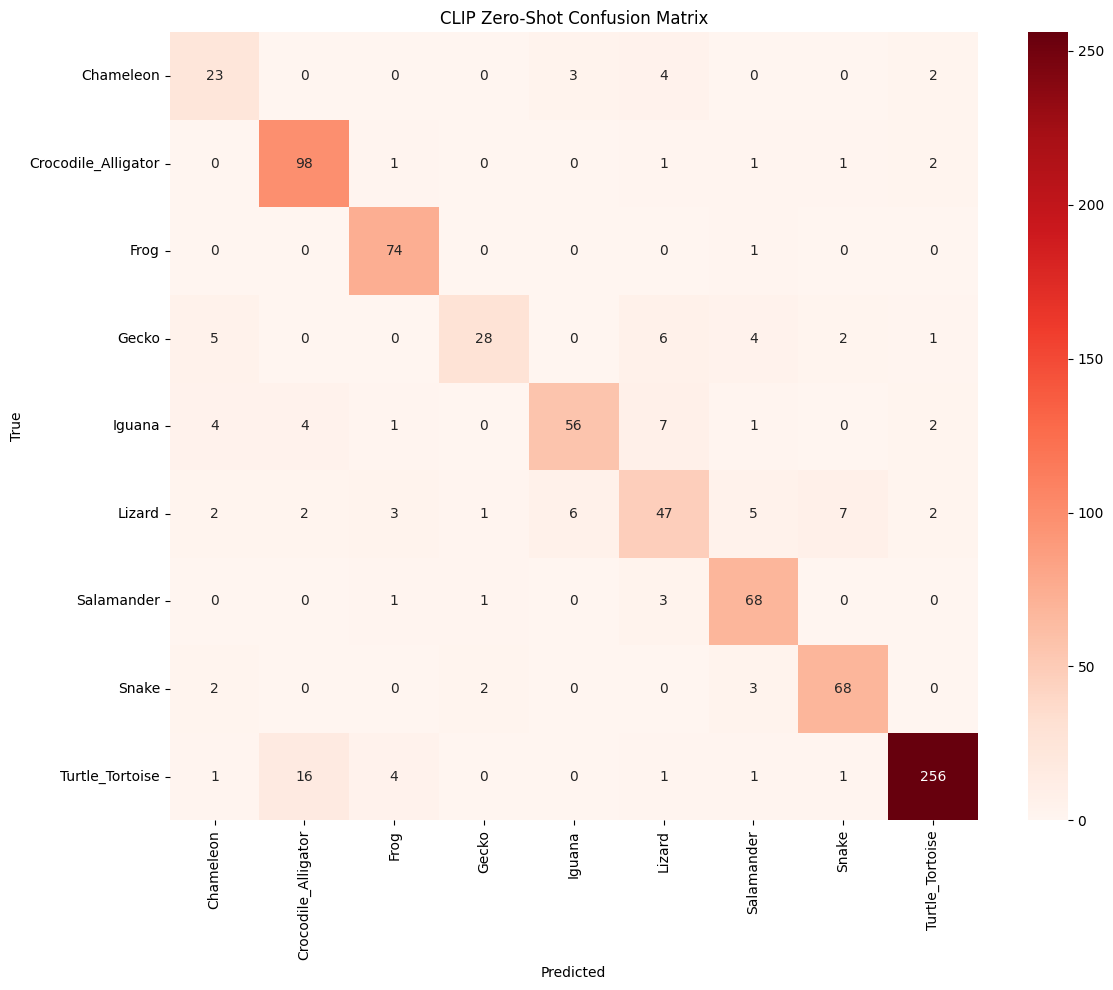

CLIP Zero-Shot Classification Report:
                     precision    recall  f1-score   support

          Chameleon     0.6216    0.7188    0.6667        32
Crocodile_Alligator     0.8167    0.9423    0.8750       104
               Frog     0.8810    0.9867    0.9308        75
              Gecko     0.8750    0.6087    0.7179        46
             Iguana     0.8615    0.7467    0.8000        75
             Lizard     0.6812    0.6267    0.6528        75
         Salamander     0.8095    0.9315    0.8662        73
              Snake     0.8608    0.9067    0.8831        75
    Turtle_Tortoise     0.9660    0.9143    0.9394       280

           accuracy                         0.8599       835
          macro avg     0.8193    0.8202    0.8147       835
       weighted avg     0.8635    0.8599    0.8583       835



In [20]:
# Import and install the CLIP model
!pip install git+https://github.com/openai/CLIP.git

# Compare with CLIP zero-shot model
import clip
from PIL import Image

def evaluate_clip_zeroshot(test_dir, class_names):
    """
    Evaluate CLIP zero-shot performance on the test dataset.
    """
    # Load CLIP model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model, preprocess = clip.load("ViT-B/32", device=device)
    
    # Prepare text prompts
    text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in class_names]).to(device)
    
    all_predictions = []
    all_labels = []
    
    # Loop through test dataset
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(test_dir, class_name)
        for img_name in tqdm(os.listdir(class_dir), desc=f'Processing {class_name}'):
            # Load and preprocess image
            img_path = os.path.join(class_dir, img_name)
            image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
            
            # Calculate features
            with torch.no_grad():
                image_features = model.encode_image(image)
                text_features = model.encode_text(text_inputs)
                
                # Normalize features
                image_features /= image_features.norm(dim=-1, keepdim=True)
                text_features /= text_features.norm(dim=-1, keepdim=True)
                
                # Calculate similarity and get prediction
                similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
                values, indices = similarity[0].topk(1)
                
                predicted_idx = indices.item()
                all_predictions.append(predicted_idx)
                all_labels.append(class_idx)
    
    # Calculate metrics
    report = classification_report(all_labels, all_predictions, target_names=class_names, digits=4)
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    
    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('CLIP Zero-Shot Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    return report, conf_matrix

# Evaluate CLIP
clip_report, clip_conf_matrix = evaluate_clip_zeroshot('data/test', class_names)
print('CLIP Zero-Shot Classification Report:')
print(clip_report)

In [21]:
# Create model card and prepare for Hugging Face
import json

# Save class mapping
class_mapping = {i: class_name for i, class_name in enumerate(class_names)}
with open('class_mapping.json', 'w') as f:
    json.dump(class_mapping, f)

# Save model in PyTorch format
torch.save({
    'model_state_dict': model.state_dict(),
    'class_mapping': class_mapping,
    'input_size': 224,
    'model_name': 'resnet50'
}, 'reptile_classifier_model.pth')

print("Model and class mapping saved successfully!")

Model and class mapping saved successfully!


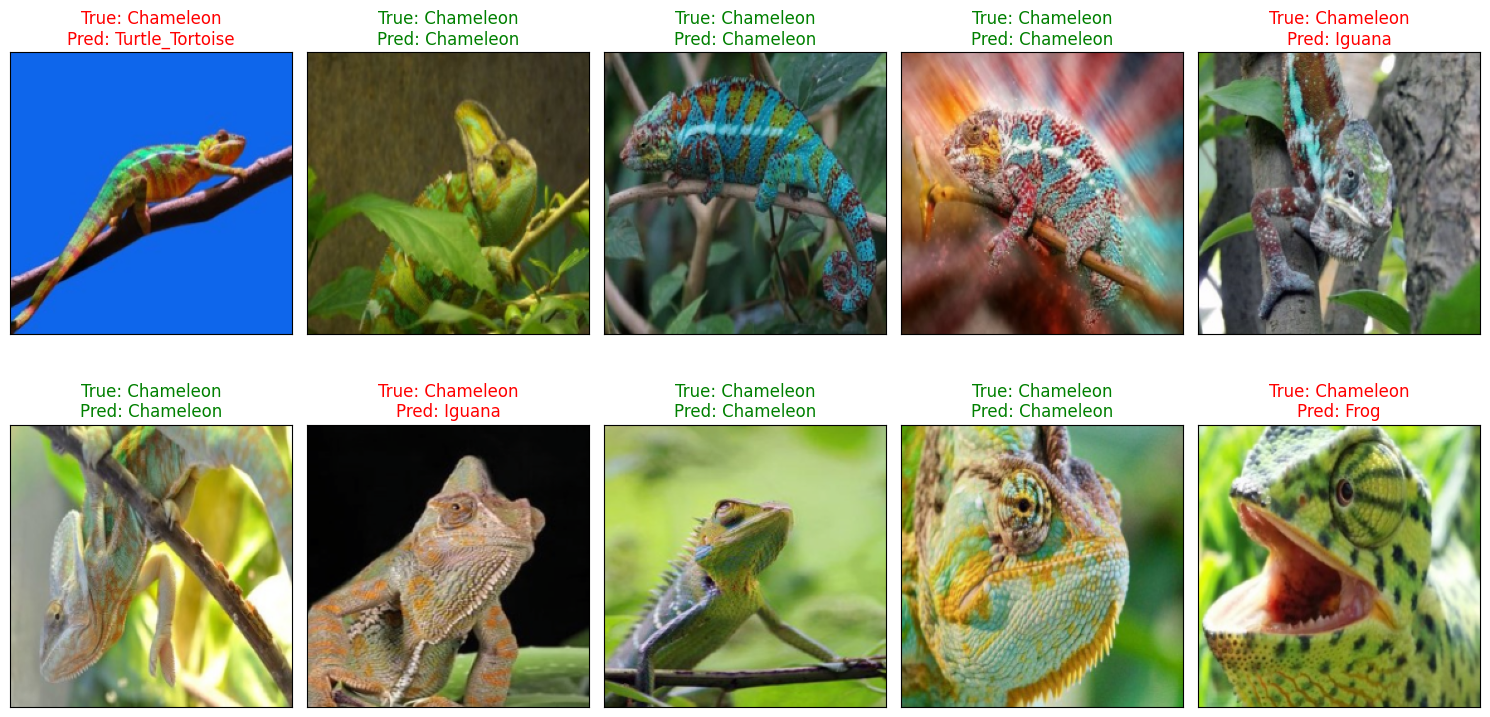

In [23]:
# Visualize some predictions
import numpy as np  # Füge diesen Import hinzu

def visualize_predictions(model, test_loader, class_names, num_images=10):
    """
    Visualize predictions on some test images.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    # Get a batch of test images
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    
    # Make predictions
    with torch.no_grad():
        outputs = model(images.to(device))
        _, preds = torch.max(outputs, 1)
    
    # Plot images with true and predicted labels
    fig = plt.figure(figsize=(15, 8))
    for i in range(min(num_images, len(images))):
        ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        
        # Convert tensor to image
        img = images[i].numpy().transpose((1, 2, 0))
        
        # De-normalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        ax.imshow(img)
        
        # Set title with true and predicted labels
        title_color = 'green' if preds[i] == labels[i] else 'red'
        ax.set_title(f'True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}', 
                    color=title_color)
    
    plt.tight_layout()
    plt.show()

# Visualize some predictions
visualize_predictions(model, test_loader, class_names)